In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import cv2

try:
    from PIL import Image
except ImportError:
    import Image

In [4]:
IMAGES_DIR_PATH="./random-cars-dataset/images"
LABELS_DIR_PATH="./random-cars-dataset/license-numbers"

In [5]:
import os
images=[f for f in os.listdir(IMAGES_DIR_PATH)]

index: 55
image: ./random-cars-dataset/images/Cars306.png
width: 400, height: 400


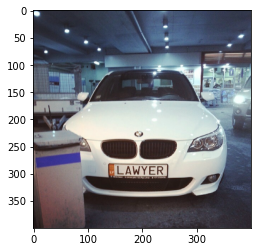

In [244]:
from random import randint

#randomly selecting an image
index=randint(0,len(images)-1)
img_path=f'{IMAGES_DIR_PATH}/{images[index]}'

#getting image size
im = Image.open(img_path)
width,height= im.size

print(f"index: {index}")
print(f"image: {img_path}")
print(f"width: {width}, height: {height}")

#displaying image
import cv2
img=cv2.imread(img_path)
plt.imshow(img)

## Detection

C:\Users\HP\Desktop\ML\ANPR\yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='.././random-cars-dataset/images/Cars306.png', update=False, view_img=False, weights=['./runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/1 C:\Users\HP\Desktop\ML\ANPR\yolov5\..\random-cars-dataset\images\Cars306.png: 640x640 1 license_plate, Done. (0.366s)
Results saved to runs\detect\exp
8 labels saved to runs\detect\exp\labels
Done. (0.400s)
134 276 250 322
C:\Users\HP\Desktop\ML\ANPR


YOLOv5  c9e3c02 torch 1.8.1+cpu CPU

Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS


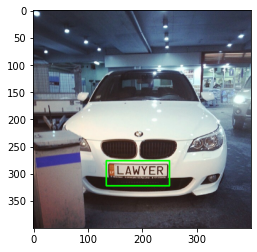

In [245]:
%cd yolov5
!python detect.py --weights ./runs/train/exp/weights/best.pt --source ../{img_path} --save-txt --exist-ok

#opening predicting bounding box file
f_name=images[index].split('.')[0]
label_file=open(f'./runs/detect/exp/labels/{f_name}.txt')

#reading line
s=label_file.readline().replace('\n','').split(' ')

#******extracting bounding box********#
s=[ float(i) for i in s]    #[conf center_x center_y width height] 

bottom_x=((2*s[1]+s[3])/2)
top_x=bottom_x-s[3]

bottom_y=((2*s[2]+s[4])/2)
top_y=bottom_y-s[4]

top_x=int(top_x*width)
bottom_x=int(bottom_x*width)

top_y=int(top_y*height)
bottom_y=int(bottom_y*height)
#*************************************#

print(f'{top_x} {top_y} {bottom_x} {bottom_y}')

img=cv2.rectangle(img,(top_x,top_y),(bottom_x,bottom_y),(0,255,0),2)
plt.imshow(img)

%cd ..

## Image pre-processing

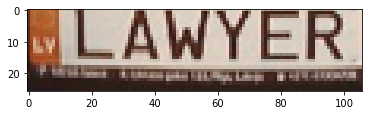

In [247]:
#cropping the license plate from the original image
plate=img[top_y+10:bottom_y-10,top_x+5:bottom_x-5]
plt.imshow(plate)

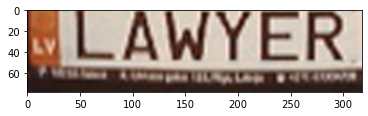

In [248]:
# resize image to three times as large as original for better readability
plate=cv2.resize(plate,None,fx=3,fy=3,interpolation=cv2.INTER_CUBIC)
plt.imshow(plate,cmap="gray")

#storing plate copy for displaying segmentation
import copy
plate_copy=copy.copy(plate)

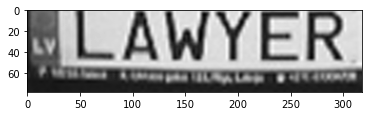

In [249]:
#converting to gray scale
plate=cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)
plt.imshow(plate,cmap="gray")

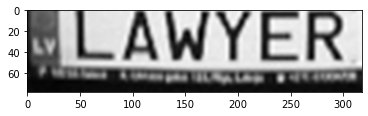

In [250]:
plate=cv2.GaussianBlur(plate, (5,5), 0)
plt.imshow(plate,cmap="gray")

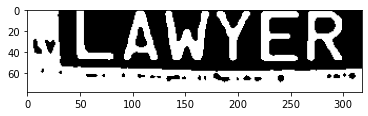

In [251]:
plate=cv2.threshold(plate, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
plt.imshow(plate, cmap="gray")

## Character Segmentation

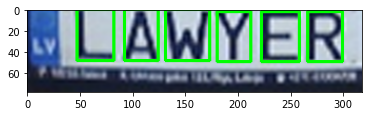

No of characters: 6


In [252]:
contours,_=cv2.findContours(plate, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
chars=[]

for cont in contours:
    x,y,w,h=cv2.boundingRect(cont)
    
    #w: width of character
    #h height of character
    
    #shape of plate
    height_of_plate,width_of_plate=plate.shape
    
    #.......removing noise........#
    
    #if char is too wide then skip
    if width_of_plate<2*w: continue        
        
    #if char is too short in height then skip
    if height_of_plate>3*h: continue
        
    #if char h/w ratio is less than 1
    if h/float(w)<1: continue
        
    #if area is less than 100 pixels
    if h*w<100: continue
        
    #.............................#
    
    #appending valid contour
    chars.append(cont)
    
    #drawing segment for the character on the plate
    plate_copy=cv2.rectangle(plate_copy,(x,y),(x+w,y+h),(0,255,0),2)


#displaying segmented plate
plate_copy=cv2.cvtColor(plate_copy,cv2.COLOR_BGR2RGB)
plt.imshow(plate_copy)
plt.show()

#number of characters segmented
print(f"No of characters: {len(chars)}")

## Character Recognition

In [253]:
#utility function to convert number(0-35) to label(0-9, A-Z)
def to_label(n):
    if n<=9:
        return str(n)
    
    return chr(n-10+ord('A'))

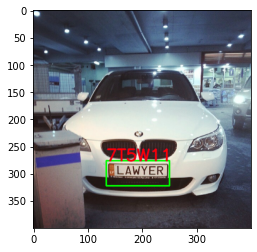

In [258]:
from itertools import chain
# from google.colab.patches import cv2_imshow



#loading recognition model
from keras.models import load_model
char_recognizer=load_model('char_recog_lenet_model.h5')


label=""
index=0

#iterating over contours
for char in chars:
    x,y,w,h=cv2.boundingRect(char) #w: width of character, h: height of character
        
    roi=plate[y:y+h,x:x+w]
    
    #adding padding
    #roi=cv2.copyMakeBorder(roi,5,5,5,5,cv2.BORDER_CONSTANT,value=[0,0,0])
    
    #resizing image to model input format (28x28)
    roi=cv2.resize(roi,(28,28))
    
    #converting roi into required format
    roi=roi.reshape(28,28,1)
    
    
    #predicting label using model
    pred=char_recognizer.predict(np.array([roi]))
    
    #finding label mith max probability
    pred=np.argmax(pred)
    
    label+=to_label(pred)
    
    index+=1

    
img=cv2.putText(img,label,(top_x,top_y),cv2.FONT_HERSHEY_SIMPLEX,1,(0, 0, 255),2,cv2.LINE_AA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)